# Forecasting model selection

## Setup 

In [46]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from script import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = '../data/405.txt'
IMG_PATH = '../img/'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPEED": "speed",
    # "AX": "nAxles",
    "GW_TOT": "weight",
    # "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)

# Drop exact duplicates
data = data.drop_duplicates()

# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format="%Y-%m-%d %H:%M:%S.%f")
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


## Feature engineering

### Resampling

We first index out dataset by the crossing time of each vehicle. We discard any data after October 21st 2019. As seen in the data exploration notebook, this is the last date before a gap in the data, followed by the COVID pandemic.

In [3]:
# Index by crossing time
feature_cols = [col for col in data.columns if col != 'crossTime']
features = data[feature_cols]
features.index = data.crossTime

# Truncate data to have ignore COVID pandemic 
start_of_covid = "2019-10-21"
features = features.truncate(after=start_of_covid)

features.head()

,speed,weight
crossTime,,
2011-04-01 00:41:31.400,106,15980
2011-04-01 00:42:10.500,116,3630
2011-04-01 00:47:15.700,84,18480
2011-04-01 01:23:37.200,88,11050
2011-04-01 01:33:23.400,89,30330


We then resample our data to a 1h interval. We sum the speed and weight columns and add a third column,  `n_vehicles`. It represents the number of vehicles travelling in that hour.

In [4]:
sampling_interval = '1h'

# Downsample and add vehicle counts
resampled = features.resample(sampling_interval)
features = resampled.sum()
features['n_vehicles'] = resampled.size()

features.head()

,speed,weight,n_vehicles
crossTime,,,
2011-04-01 00:00:00,306,38090,3
2011-04-01 01:00:00,540,107870,6
2011-04-01 02:00:00,258,69670,3
2011-04-01 03:00:00,350,43060,4
2011-04-01 04:00:00,1211,290270,14


### New features

#### HGV Driving restrictions

Heavy goods vehicles are restricted from travelling on sundays, and from 10PM to 5AM all other days, in Switerland.
We add a `is_legal` indicator feature to reflect this

In [5]:
legal_driving_start = 5  #  5 AM
legal_driving_end = 22   # 10 PM
legal_driving_duration = legal_driving_end - legal_driving_start
sunday = 6

# Extract day of week and hours of each row, so that hours starts at 5 AM 
dayofweek = pd.Series(features.index.dayofweek, index=features.index)
hours = pd.Series(features.index.hour, index=features.index)
shifted_hours = hours - legal_driving_start

# Add column
features['is_legal'] = (((0 <= shifted_hours) & (shifted_hours < legal_driving_duration))).astype(int)
features.head(10)

,speed,weight,n_vehicles,is_legal
crossTime,,,,
2011-04-01 00:00:00,306,38090,3,0
2011-04-01 01:00:00,540,107870,6,0
2011-04-01 02:00:00,258,69670,3,0
2011-04-01 03:00:00,350,43060,4,0
2011-04-01 04:00:00,1211,290270,14,0
2011-04-01 05:00:00,3398,825050,39,1
2011-04-01 06:00:00,7120,1310680,81,1
2011-04-01 07:00:00,12966,2287160,146,1
2011-04-01 08:00:00,13541,2729830,156,1


#### Time features

Datetime column `crossTime` not useful to a model in its string form. We extract time of day, time of the week, and/or time of the year information to analyse periodicity. In order to deal with periodicity, we use sine and cosine transforms to get usable signals.

In [7]:
# Corresponding length in seconds for day, week, year
minute_s = 60
hour_s = minute_s * 60
day_s = 24 * hour_s # 24h x 60m x 60s
week_s = 7 * day_s
year_s = 365.2425 * day_s

In [8]:
features = add_time_period_cols(features, day_s, 'day')
features = add_time_period_cols(features, week_s, 'week')
features = add_time_period_cols(features, year_s, 'year')

features.head(2)

,speed,weight,n_vehicles,is_legal,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
crossTime,,,,,,,,,,
2011-04-01 00:00:00,306,38090,3,0,1.461574e-12,1.000000,0.781831,0.62349,0.999768,0.021556
2011-04-01 01:00:00,540,107870,6,0,2.588190e-01,0.965926,0.804598,0.59382,0.999783,0.020839


We plot the `year_sin` and `year_cos` features to show their period of 1 year on our data.

Text(0.5, 1.0, 'Sine/Cosine value')

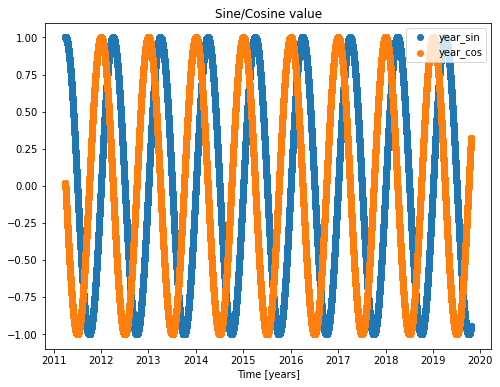

In [9]:
plt.scatter(y=np.array(features['year_sin']), x=features.index,
            label='year_sin')
plt.scatter(y=np.array(features['year_cos']), x=features.index,
            label='year_cos')
plt.xlabel('Time [years]')
plt.legend(loc='upper right')
plt.title('Sine/Cosine value')

### Splitting and normalizing

We split out dataset into a training, validation, and test dataset. The three datasets are chronologically consecutive, training being the oldest.

The test and validation datasets contain 2 years ($2 \cdot 52$ weeks) of data. The training dataset contains the remaining data.

We also normalize the columns of each dataset using standard scaling, based on the mean and standard deviation of the training data.

In [10]:
train, val, test, train_mean, train_std = split_norm_data(features, return_mean_std=True, splitter=year_splitter)

In [11]:
hours_in_52_weeks = 24 * 7 * 52

def describe_dataset(data, name):
    print(name)
    print(f"\tNumber of years: {len(data) / hours_in_52_weeks:.2f}")
    
    mn, mx = data.index.min(), data.index.max() 
    
    print(f"\tRanging from: {mn}")
    print(f"\t        to:   {mx}")
    
describe_dataset(train, "Training")
describe_dataset(val, "Validation")
describe_dataset(test, "Testing")

Training
	Number of years: 4.59
	Ranging from: 2011-04-01 00:00:00
	        to:   2015-10-25 23:00:00
Validation
	Number of years: 2.00
	Ranging from: 2015-10-25 23:00:00
	        to:   2017-10-22 23:00:00
Testing
	Number of years: 2.00
	Ranging from: 2017-10-22 23:00:00
	        to:   2019-10-20 23:00:00


### Windowing and zero-week filtering

We create a window object for our inputs and outputs. This object takes the data and splits it into (input, output) tuples. Is does so as follows:

* It specifies a window of (1 year + 1 week). The input data will be the first week of the window, the output the last. This means that our model will predict a week using the same week of the previous year.

* It takes the dataset and slides the window along the dataset, one hour at a time. Each slide creates a new (input_week, output_week) tuple.

* It creates a new Tensorflow dataset from the Pandas DataFrame. It shuffles the tuples and and batches them into batches of 32 for training

* It filters (input, output) tuples if either the input or the output number of vehicles is 0 for the whole week. It does so when transforming the data from from a Pandas DataFrame to a TensorFlow Dataset.



In [12]:
WEEK_STEPS = 7 * 24
YEAR_STEPS = 52 * WEEK_STEPS
SHIFT_STEPS = YEAR_STEPS      # predict same week of following year

labels = ['speed', 'weight', 'n_vehicles'] # What we want to predict
num_features = len(train.columns)
num_labels = len(labels)

In [13]:
week_window = make_window(train, val, test, train_mean, train_std,
                          input_w=WEEK_STEPS, label_w=WEEK_STEPS,
                          shift=SHIFT_STEPS, label_cols=labels)
week_window

Total window size: 8904
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [8736 8737 8738 8739 8740 8741 8742 8743 8744 8745 8746 8747 8748 8749
 8750 8751 8752 8753 8754 8755 8756 8757 8758 8759 8760 8761 8762 8763
 8764 8765 8766 8767 8768 8769 8770 8771 8772 8773 8774 8775 8776 8777
 8778 8779 8780 8781 8782 8783 8784 8785 8786 8787

Here is a plot of a sample of weeks from the training dataset generated with our window:

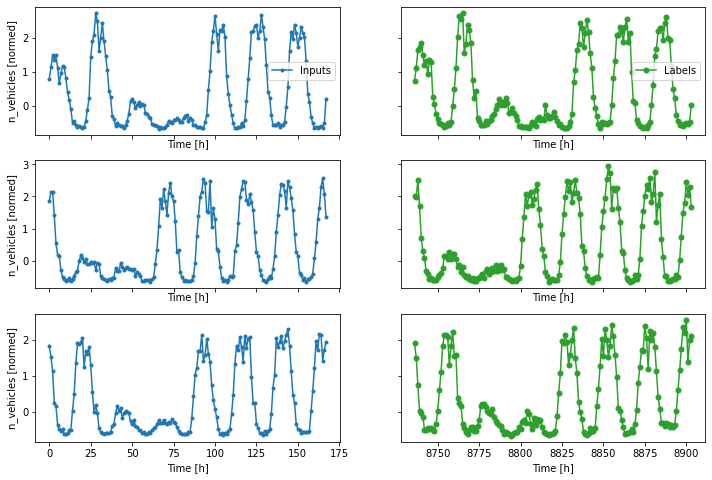

<Figure size 576x432 with 0 Axes>

In [14]:
week_window.plot()
plt.show()
plt.clf()

## Model prediction

We will train various models to predict our data. This will allow to choose the best performing model to generate our new data.

In [15]:
MODELS_PATH = "models/"

In [16]:
metrics = [tf.losses.MeanSquaredError(),
           tf.metrics.MeanAbsoluteError()]

### Baseline

The first model is the simplest one, it simply outputs the . We will compare our predictions 

In [17]:
class Baseline(tf.keras.Model):
    """Model that outputs its input of shape (batch, time, features)
       If `label_indices` is None, outputs the whole time range, 
       `input[:, label_indices, :]` otherwise.
       If `label_col_indices` is None, outputs all features, 
       `input[:, :, label_col_indices]` otherwise.otherwise"""
    
    def __init__(self, label_indices=None, label_col_indices=None):    
        super().__init__()
        self.label_indices = label_indices
        self.label_col_indices = label_col_indices

    def call(self, inputs):
        """Returns the desired portion of the input"""
        result = inputs
        
        if self.label_indices:
            result = tf.gather(result, self.label_indices, axis=1)
            
        if self.label_col_indices:
            result = tf.gather(result, self.label_col_indices, axis=2)
        
        return result

In [18]:
# Find index of ouput features
label_col_indices = [i for i, col in enumerate(train.columns) if col in labels]


baseline = Baseline(label_col_indices=label_col_indices)
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=metrics)

### Linear 

In [19]:
linear = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, time*features]
    tf.keras.layers.Flatten(),
    # Shape => [batch, 1, time*features]
    tf.keras.layers.Dense(WEEK_STEPS*num_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, time, features]
    tf.keras.layers.Reshape([WEEK_STEPS, num_labels])
])

In [20]:
lin_history = compile_and_fit(linear, week_window, metrics=metrics)
IPython.display.clear_output()

In [21]:
linear.save(MODELS_PATH + "sel-linear")

2021-12-21 19:12:39.172019: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/sel-linear/assets


### Deep Neural Network

In [22]:
dense = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, time*features]
    tf.keras.layers.Flatten(),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, week_steps*features]
    tf.keras.layers.Dense(WEEK_STEPS*num_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, week_steps, features]
    tf.keras.layers.Reshape([WEEK_STEPS, num_labels])
])

In [23]:
dense_history = compile_and_fit(dense, week_window, metrics=metrics)
IPython.display.clear_output()

In [24]:
dense.save(MODELS_PATH + "sel-dense")

INFO:tensorflow:Assets written to: models/sel-dense/assets


In [25]:
conv_hist = compile_and_fit(conv, week_window, metrics=metrics)
IPython.display.clear_output()

NameError: name 'conv' is not defined

In [ ]:
conv.save(MODELS_PATH + "sel-conv")

### Recurrent Neural Network (LSTM)

In [26]:
rnn = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(WEEK_STEPS*num_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([WEEK_STEPS, num_labels])
])

In [27]:
rnn_hist = compile_and_fit(rnn, week_window, metrics=metrics)
IPython.display.clear_output()

In [28]:
rnn.save(MODELS_PATH + "sel-rnn")

INFO:tensorflow:Assets written to: models/sel-rnn/assets


INFO:tensorflow:Assets written to: models/sel-rnn/assets


## Performance evaluation and model selection

In [29]:
val_performance = {}
test_performance = {}

### Baseline

In [30]:
val_performance['Baseline'] = baseline.evaluate(week_window.val)
test_performance['Baseline'] = baseline.evaluate(week_window.test, verbose=0)
IPython.display.clear_output()

### Linear

In [31]:
val_performance['Linear'] = linear.evaluate(week_window.val)
test_performance['Linear'] = linear.evaluate(week_window.test, verbose=0)
IPython.display.clear_output()

### Dense

In [32]:
val_performance['Dense'] = dense.evaluate(week_window.val)
test_performance['Dense'] = dense.evaluate(week_window.test, verbose=0)
IPython.display.clear_output()

### RNN

In [33]:
val_performance['RNN'] = rnn.evaluate(week_window.val)
test_performance['RNN'] = rnn.evaluate(week_window.test, verbose=0)
IPython.display.clear_output()

### Performance

In [34]:
def plot_metric(metric_name):
    x = np.arange(len(test_performance))
    width = 0.3
    metric_index = dense.metrics_names.index(metric_name)
    val_mae = [v[metric_index] for v in val_performance.values()]
    test_mae = [v[metric_index] for v in test_performance.values()]

    plt.ylabel(f'{metric_name} [Weight, normalized]')
    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=test_performance.keys(),
               rotation=45)
    _ = plt.legend()

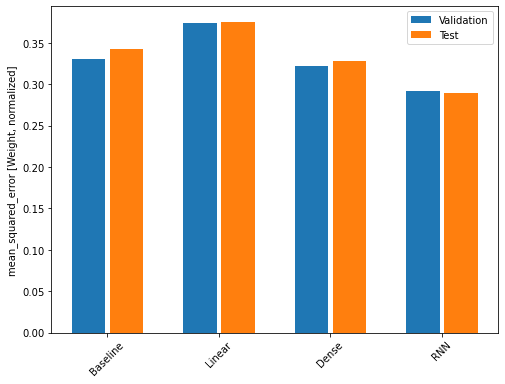

In [42]:
plot_metric('mean_squared_error')

In [43]:
print("Mean squared error")
for name, value in test_performance.items():
    print(f'{name:12s}: {value[0]:0.4f}')

Mean squared error
Baseline    : 0.3430
Linear      : 0.3753
Dense       : 0.3273
RNN         : 0.2889


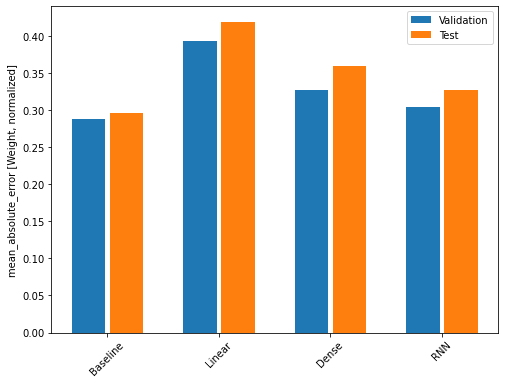

In [44]:
plot_metric('mean_absolute_error')

In [45]:
print("Mean absolute error")
for name, value in test_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Mean absolute error
Baseline    : 0.3430
Linear      : 0.3752
Dense       : 0.3276
RNN         : 0.2888
